In [105]:
import sys
sys.path.append('../data')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

## **archivos**

In [71]:
fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

In [72]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        print(fname)
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)

data_file1_040124.mat
data2_file5_030124.mat
datosconsu_021023_medio_1.mat
datahigh_file5_040124.mat
data_file3_040124.mat
datosconsu_021023_alto_600s_1.mat
data2_file2_030124.mat
datosconsu_021023_bajos.mat
data_file6_040124.mat
data_file5_040124.mat
datahigh_file3_040124.mat
data2_file3_030124.mat
datahigh_file1_040124.mat
datahigh_file4_040124.mat
data2_file6_030124.mat
data_file2_040124.mat


In [120]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    print(i)
    taus.append(aux.get_tau()[1])
    print(i)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15


## **psd defectos**

In [122]:
signal_sin_defectos = []
hilbert_sin_defectos = []

for i, df in enumerate(defectos_frames):

    aux,aux_hilbert= df.get_no_defectos()
    signal_sin_defectos.append(aux)
    hilbert_sin_defectos.append(aux_hilbert)
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [130]:
signal_sin_defectos[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,1.955783,0.052983,-0.002772,-0.002772+0.000572j
1,1.956441,0.053641,-0.002523,-0.002523-0.001348j
2,1.956441,0.053641,-0.002276,-0.002276-0.001518j
3,1.957756,0.054956,-0.002031,-0.002031-0.002213j
4,1.958414,0.055614,-0.001789,-0.001789-0.002321j
...,...,...,...,...
599995,1.940000,0.037200,-0.000306,-0.000306-0.000520j
599996,1.941973,0.039173,-0.000302,-0.000302-0.000674j
599997,1.944275,0.041475,-0.000298,-0.000298-0.000293j
599998,1.946576,0.043777,-0.000291,-0.000291-0.000489j


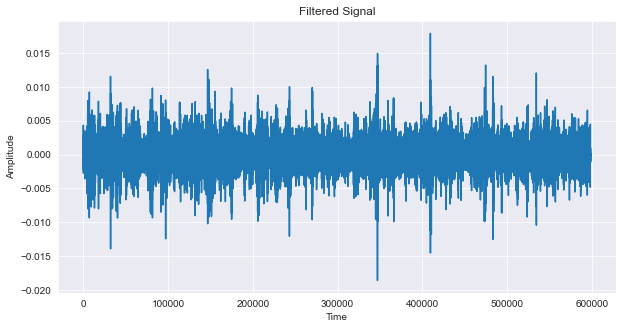

In [149]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and the sampling frequency
cutoff_freq = 200  # Specify the cutoff frequency in Hz
sampling_freq = 1000  # Specify the sampling frequency in Hz

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = cutoff_freq / (sampling_freq / 2)

# Design the filter coefficients using a Butterworth filter
order = 4  # Specify the filter order
b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

# Apply the filter to the signal
signal_filtered = []
for elem in signal_sin_defectos:
    elem = elem.dropna()
    aux = filtfilt(b, a, elem['Filtered Signal'])
    signal_filtered.append(aux)


# Plot the filtered signal
plt.figure(figsize=(10, 5))
plt.plot(signal_filtered[0], label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [132]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

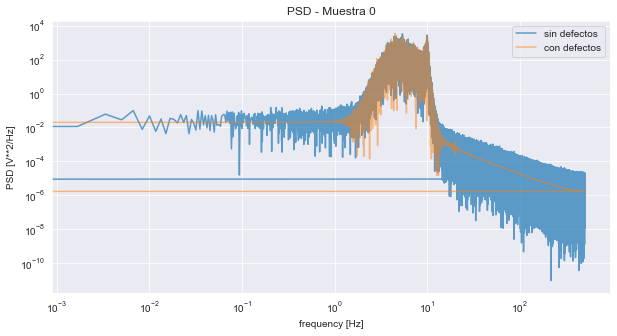

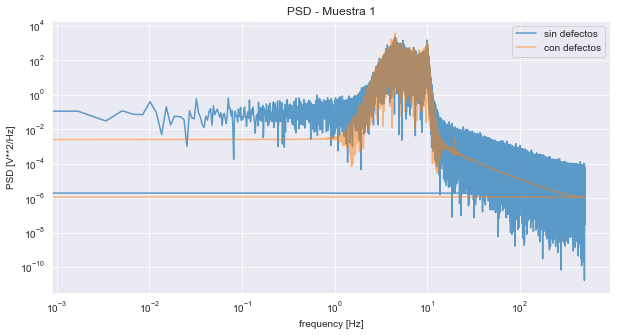

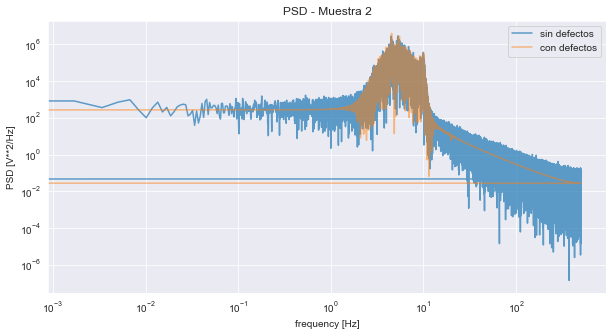

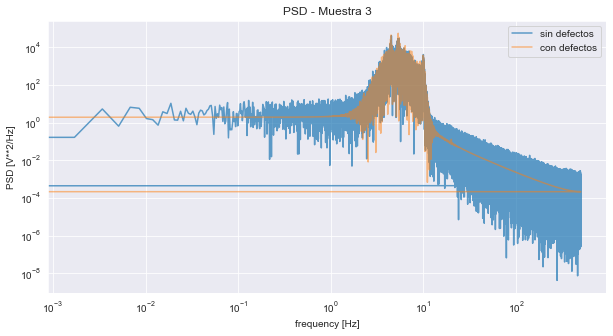

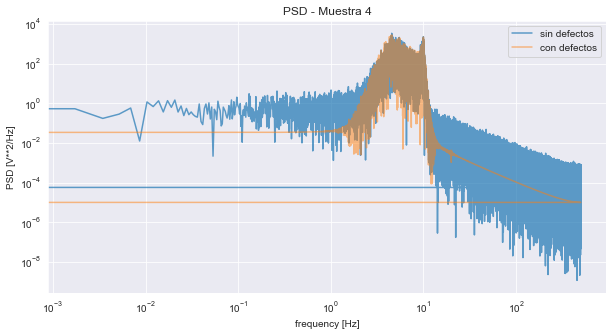

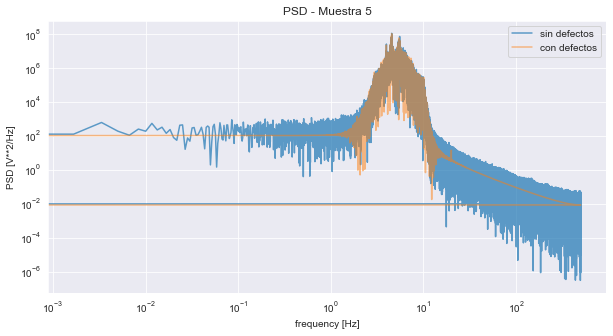

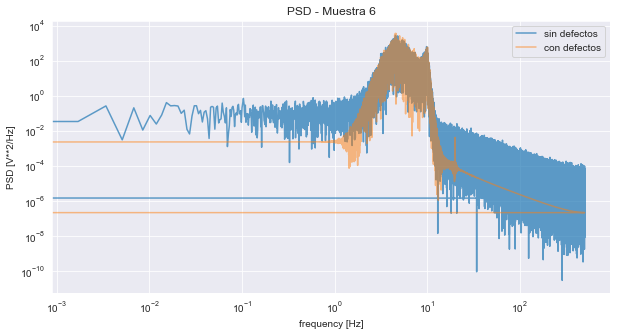

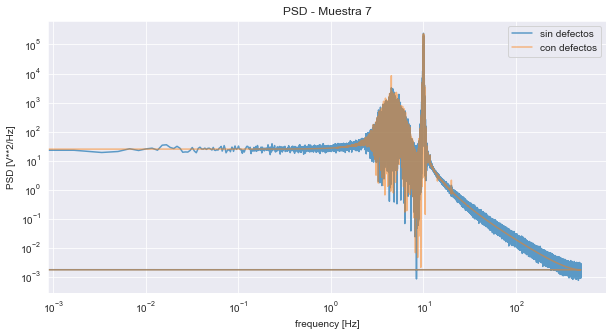

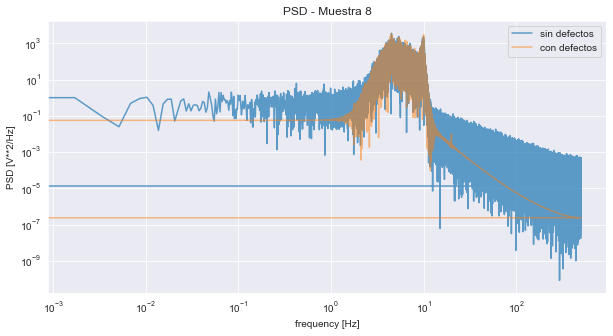

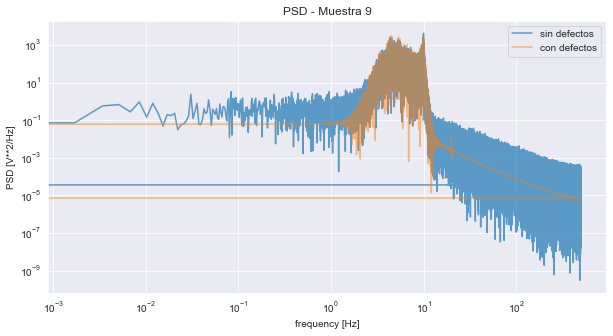

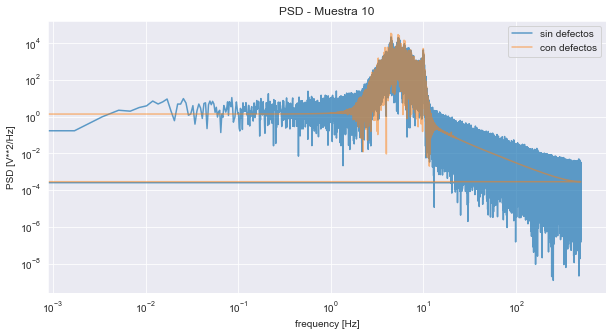

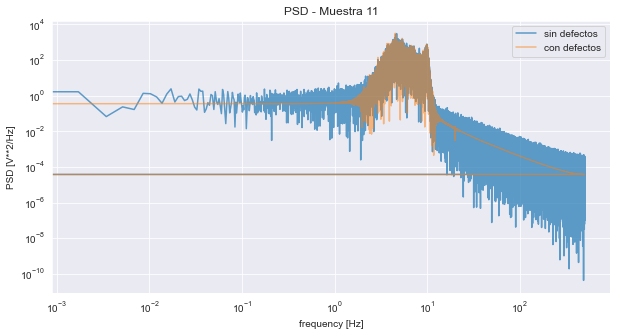

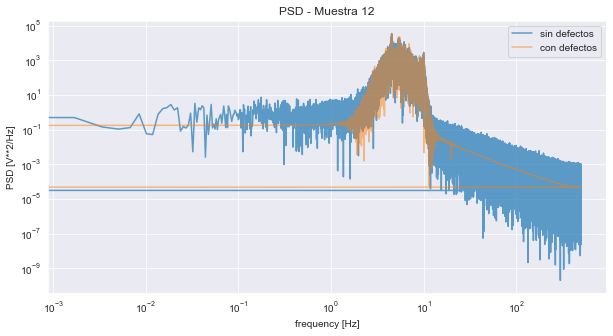

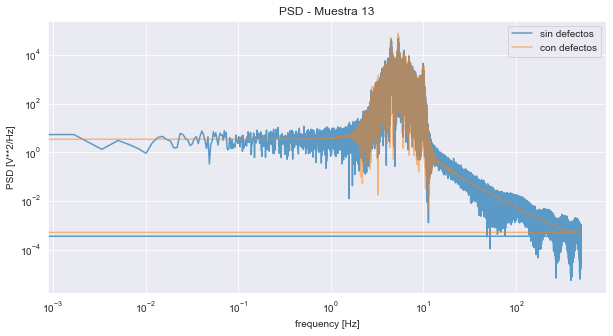

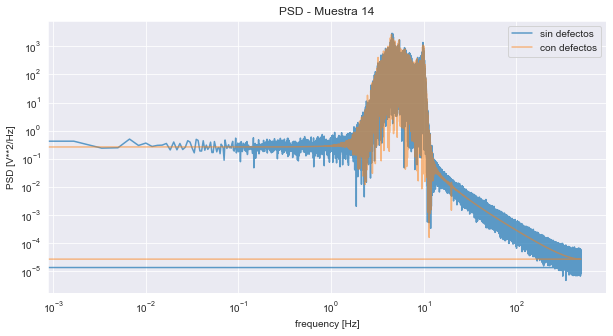

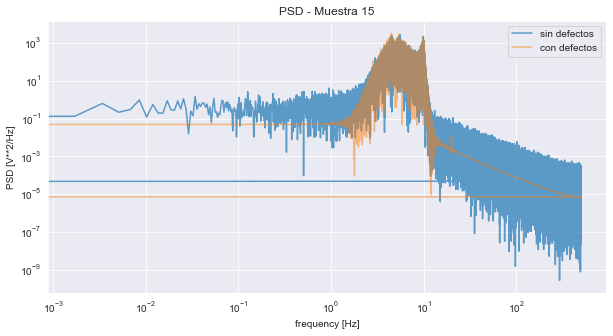

In [160]:
for i, elem in enumerate(signal_sin_defectos):
    figure = plt.figure(figsize=(10,5))
    elem = elem.dropna()
    freq1, psd1 = ffts(elem['Filtered Signal'], fs=1000)
    freq2, psd2 = ffts(frames[i]['Filtered Signal'])

    plt.loglog(freq1, psd1, label = 'sin defectos', alpha = 0.7)
    plt.loglog(freq2,psd2, label = 'con defectos', alpha = 0.5)

    plt.title(f"PSD - Muestra {i}")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

## **stats**

In [134]:
all_taus = pd.concat(taus).reset_index(drop=True)
all_taus.describe()

,duration,tau,app_time
count,1813.000000,1813.000000,1797.000000
mean,23.521236,12.692774,5138.252643
std,3.155677,1.899500,8745.798904
min,2.000000,0.000000,-2.000000
25%,21.000000,12.000000,992.000000
50%,23.000000,12.000000,2766.000000
75%,26.000000,14.000000,6203.000000
max,29.000000,26.000000,172796.000000


In [135]:
fig = go.Figure(data=[go.Histogram(x=all_taus['app_time'])])
fig.update_layout(title='Histogram of Difference', xaxis_title='Difference', yaxis_title='Count')
fig.show()


#### **distribuciones**

In [136]:
appearance_time = all_taus['app_time'].values
appearance_time = (appearance_time[~np.isnan(appearance_time)])


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,1.444846e-09,3167.935165,3184.416787,inf,0.047159,6.527616e-04
beta,2.136916e-09,4647.385591,4669.361087,inf,0.051996,1.158717e-04
chi2,2.697189e-09,4310.561335,4327.042957,inf,0.068580,8.577457e-08
burr,3.575232e-08,2913.978304,2935.953800,inf,0.512933,0.000000e+00
norm,3.830013e-08,13894.981711,13905.969459,inf,0.278299,1.493582e-123


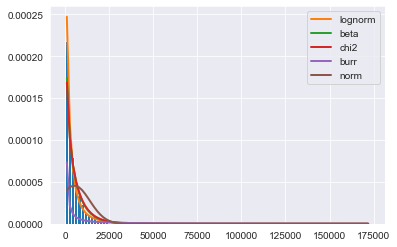

In [137]:
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()


1784


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,1.691169e-08,2877.672776,2899.619229,inf,0.104333,2.313683e-17
burr,1.953906e-08,2494.877266,2516.823720,inf,0.063578,1.033227e-06
gamma,7.388035e-08,3057.814150,3074.273990,inf,0.118793,2.152722e-22
norm,1.254990e-07,3558.971496,3569.944722,inf,0.204503,6.728855e-66
lognorm,1.650456e-07,2764.285578,2780.745418,inf,0.775705,0.000000e+00


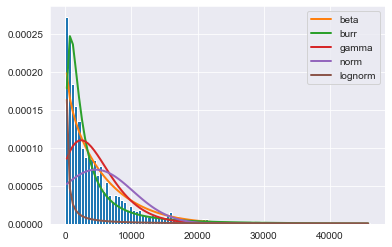

In [138]:
all_taus_2 = all_taus[all_taus['app_time'] <= 50000]
print(len(all_taus_2))

appearance_time = all_taus_2['app_time'].values
appearance_time = appearance_time[~np.isnan(appearance_time)]
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()